# Kalman Filter Implementation

References:
- https://www.mathworks.com/help/fusion/ug/pose-estimation-from-asynchronous-sensors.html
- https://stackoverflow.com/questions/1185408/converting-from-longitude-latitude-to-cartesian-coordinates
- https://proj.org/en/stable/about.html
- https://en.wikipedia.org/wiki/Geographic_coordinate_conversion#From_geodetic_to_ECEF_coordinates
- https://en.wikipedia.org/wiki/Geodetic_coordinates
- https://en.wikipedia.org/wiki/World_Geodetic_System
- https://ardupilot.org/dev/docs/extended-kalman-filter.html

Method (Steps):
1. Convert GPS long/lat measurements to relative xy-coords in meters
2. Integrate Gyro/Accel to get yaw angle (z-axis) and forward speed (y-axis), respectively
3. Use INS equations and another integration to find xy-trajectory for Gyro/Accel measurements
4. Plot measurements of $xy$ and $\theta$ across time for each sensor
5. Implement EKF
6. Use EKF to fuse sensors
7. Analyse results

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import autograd as ag

In [3]:
stat_acc_df = pd.read_csv("../data/stationary_acc.csv")
stat_gyr_df = pd.read_csv("../data/stationary_gyr.csv")
traj_acc_df = pd.read_csv("../data/traj_acc.csv")
traj_gyr_df = pd.read_csv("../data/traj_gyr.csv")
traj_gps_df = pd.read_csv("../data/traj_gps.csv")
traj_truth_df = pd.read_csv("../data/traj_truth.csv")

In [19]:
traj_acc_df.head()

,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2)
0,0.0225,-0.299,-0.282,9.57
1,0.0246,-0.370,-0.282,9.66
2,0.0267,-0.414,-0.277,9.64
3,0.0289,-0.446,-0.191,9.67
4,0.0310,-0.455,-0.153,9.73


In [20]:
traj_gyr_df.head()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
0,0.0310,0.00122,-0.000305,-0.001110
1,0.0332,0.00122,-0.001530,-0.001110
2,0.0353,-0.00122,0.000916,0.000111
3,0.0374,-0.00244,0.000916,0.000264
4,0.0396,0.00000,-0.002750,0.000111


In [ ]:
traj_gps_df.head()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
0,0.000000,45.447264,-73.798053,51.816190,0.0,61.189362,24.632000,9.429768
1,1.948017,45.446880,-73.796762,22.286429,0.0,61.189362,14.082784,14.651149
2,3.043338,45.446932,-73.796780,22.176985,0.0,61.189362,4.277642,27.384563
3,4.052077,45.446939,-73.796782,16.394296,0.0,61.189362,9.414026,15.854093
4,5.085355,45.446936,-73.796781,15.293201,0.0,61.189362,9.205843,12.037631


In [18]:
traj_gps_df.tail()

,Time (s),Latitude (°),Longitude (°),Height (m),Velocity (m/s),Direction (°),Horizontal Accuracy (m),Vertical Accuracy (m)
786,793.605199,45.446937,-73.79683,20.123425,0.001600,65.843979,1.667726,1.650350
787,794.605227,45.446937,-73.79683,20.197818,0.001356,65.966217,1.851725,1.856987
788,795.605238,45.446937,-73.79683,20.164633,0.001067,65.933029,1.699418,2.054355
789,796.605272,45.446937,-73.79683,20.172889,0.000466,65.909470,1.564583,2.236105
790,797.605318,45.446937,-73.79683,20.183647,0.000351,65.959579,1.466302,2.402915


In [21]:
traj_truth_df.head()

,Latitude (°),Longitude (°)
0,45.447014,-73.796857
1,45.447038,-73.796779
2,45.447117,-73.796843
3,45.447164,-73.796908
4,45.447196,-73.796924


In [40]:
traj_truth_lat_vec = traj_truth_df.loc[:, 'Latitude (°)'].to_numpy()
traj_truth_long_vec = traj_truth_df.loc[:, 'Longitude (°)'].to_numpy()
traj_gps_lat_vec = traj_gps_df.loc[:, 'Latitude (°)'].to_numpy()
traj_gps_long_vec = traj_gps_df.loc[:, 'Longitude (°)'].to_numpy()
traj_gps_h_vec = traj_gps_df.loc[:, 'Height (m)'].to_numpy()

In [41]:
type(traj_gps_h_vec)

numpy.ndarray

Text(0, 0.5, 'Latitude (°)')

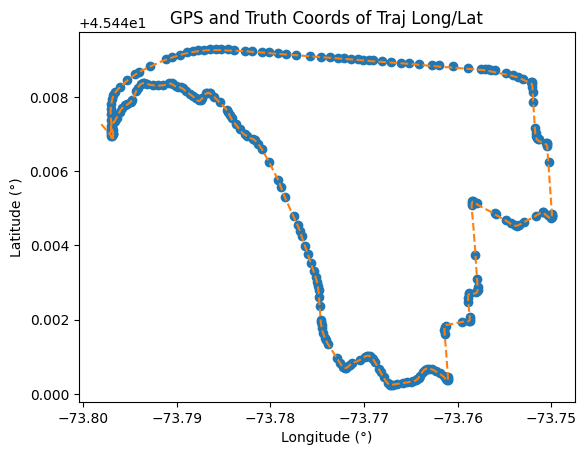

In [42]:
plt.plot(traj_truth_long_vec, traj_truth_lat_vec, 'o')
plt.plot(traj_gps_long_vec, traj_gps_lat_vec, '--')
plt.title("GPS and Truth Coords of Traj Long/Lat")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")

## Preprocessing GPS Data to Local Coordinates

First step would be to convert GPS long/lat measurements to relative xy-coords in meters.

Since IMU is in ENU coords the conversion method is as follows:
- Convert geodetic coords to ECEF coords
- Convert ECEF coords to local ENU coords 

The Prime Vertical Radius of Curvature is
$$\frac{a^2}{\sqrt{a^2\cos^2\phi + b^2\sin^2\phi}},$$
where $a = 6378137.0m$ and $b = 6356752.314245 m$ are the semi-major axis and semi-minor axis, respectively. $\phi$ is geodetic latitude and $\lambda$ is geodetic longitude.

In [102]:
def ecef_enu_rotation_mat(lat_r, long_r):
    phi_r = np.deg2rad(lat_r)
    lmbd_r = np.deg2rad(long_r)
    R = np.transpose(np.array([[-np.sin(lmbd_r), -np.sin(phi_r)*np.cos(lmbd_r), np.cos(phi_r)*np.cos(lmbd_r)],
                 [np.cos(lmbd_r), -np.sin(phi_r)*np.sin(lmbd_r), np.cos(phi_r)*np.sin(lmbd_r)],
                 [0, np.cos(phi_r), np.sin(phi_r)]]))
    return R

In [105]:
def basic_spherical_coords(lat, long):
    R = 6371000
    phi = np.deg2rad(lat)
    lmbd = np.deg2rad(long)
    x = R * np.cos(phi) * np.cos(lmbd)
    y = R * np.cos(phi) * np.sin(lmbd)
    z = R * np.sin(phi)
    return np.array([x, y, z])

In [107]:
def basic_ecef_enu(lat_r, long_r, lat_p, long_p):
   R = ecef_enu_rotation_mat(lat_r, long_r) 
   x_r, y_r, z_r = basic_spherical_coords(lat_r, long_r)
   x_p, y_p, z_p = basic_spherical_coords(lat_p, long_p)
   delta = np.array([x_p - x_r, y_p - y_r, z_p - z_r])
   delta.reshape((delta.shape[0], 1))
   enu = R @ delta
   return enu

In [52]:
def prime_vert_radius_curvature(lat, a=6378137.0, b=6356752.314245):
    phi = np.deg2rad(lat)
    return a**2 / np.sqrt(a**2 * np.cos(phi)**2 + b**2 * np.sin(phi)**2)

In [53]:
prime_vert_radius_curvature(45)

np.float64(6388838.290121239)

In [54]:
def geodet_to_ecef(lat, long, h):
    a = 6378137.0
    b = 6356752.314245
    phi = np.deg2rad(lat)
    lmbd = np.deg2rad(long)
    N = prime_vert_radius_curvature(lat)
    x = (N + h) * np.cos(phi) * np.cos(lmbd)
    y = (N + h) * np.cos(phi) * np.sin(lmbd)
    z = (b**2 / a**2 * N + h) * np.sin(phi)
    return x, y, z

In [103]:
def ecef_enu(lat_r, long_r, h_r, lat_p, long_p, h_p):
    R = ecef_enu_rotation_mat(lat_r, long_r)
    x_r, y_r, z_r = geodet_to_ecef(lat_r, long_r, h_r)
    x_p, y_p, z_p = geodet_to_ecef(lat_p, long_p, h_p)
    delta = np.array([x_p - x_r, y_p - y_r, z_p - z_r])
    delta.reshape((delta.shape[0], 1))
    enu = R @ delta
    return enu

In [58]:
lat_r = traj_gps_lat_vec[0]
long_r = traj_gps_long_vec[0]
h_r = traj_gps_h_vec[0]
lat_p = traj_gps_lat_vec[-1]
long_p  = traj_gps_long_vec[-1]
h_p = traj_gps_h_vec[-1]
f"ref: ({lat_r}, {long_r}, {h_r}); p: ({lat_p}, {long_p}, {h_p})"

'ref: (45.4472644, -73.7980526, 51.81619023); p: (45.44693658, -73.79682967, 20.1836471)'

In [104]:
# Correction: conv deg2rad for np.
enu_res = ecef_enu(lat_r, long_r, h_r, lat_p, long_p, h_p)
f"x: {enu_res[0]}m, y: {enu_res[1]}m, z: {enu_res[2]}m"

'x: 95.67188449876879m, y: -36.43347151212124m, z: -31.633363672493026m'

In [76]:
enu_res = ecef_enu(lat_r, long_r, h_r, lat_r, long_r, h_r)
f"x: {enu_res[0]}m, y: {enu_res[1]}m, z: {enu_res[2]}m"

'x: 0.0m, y: 0.0m, z: 0.0m'

In [78]:
ecef_enu_ref = partial(ecef_enu, lat_r, long_r, h_r)
enu_res = ecef_enu_ref(lat_r, long_r, h_r)
print(f"x: {enu_res[0]}m, y: {enu_res[1]}m, z: {enu_res[2]}m")
enu_res = ecef_enu_ref(lat_p, long_p, h_p)
print(f"x: {enu_res[0]}m, y: {enu_res[1]}m, z: {enu_res[2]}m")

x: 0.0m, y: 0.0m, z: 0.0m
x: 95.67188449876879m, y: -36.43347151212124m, z: -31.633363672493026m


In [ ]:
traj_gps_lat_vec.shape, traj_gps_long_vec.shape, traj_gps_h_vec.shape

((791,), (791,), (791,))

In [70]:
traj_gps_geodet_vec = np.stack((traj_gps_lat_vec, traj_gps_long_vec, traj_gps_h_vec), axis=1)
traj_gps_geodet_vec.shape, traj_gps_geodet_vec

((791, 3),
 array([[ 45.4472644 , -73.7980526 ,  51.81619023],
        [ 45.44688041, -73.79676242,  22.28642877],
        [ 45.44693199, -73.79678013,  22.17698474],
        ...,
        [ 45.44693656, -73.79682976,  20.1646328 ],
        [ 45.44693658, -73.79682968,  20.17288877],
        [ 45.44693658, -73.79682967,  20.1836471 ]]))

In [85]:
# Get x/y gps vecs.
traj_gps_enu_vec = np.apply_along_axis(lambda row: ecef_enu_ref(row[0], row[1], row[2]), 1, traj_gps_geodet_vec)
traj_gps_enu_vec.shape, traj_gps_enu_vec

((791, 3),
 array([[  0.        ,   0.        ,   0.        ],
        [100.93309925, -42.67618568, -29.53070173],
        [ 99.54752171, -36.9435595 , -29.64008818],
        ...,
        [ 95.6648434 , -36.43569433, -31.65237788],
        [ 95.67110202, -36.43347146, -31.64412199],
        [ 95.6718845 , -36.43347151, -31.63336367]]))

In [87]:
for i in range(10):
    print(f"x: {traj_gps_enu_vec[i][0]}m, y: {traj_gps_enu_vec[i][1]}m, z: {traj_gps_enu_vec[i][2]}m")

x: 0.0m, y: 0.0m, z: 0.0m
x: 100.93309925478106m, y: -42.676185683988834m, z: -29.530701727832785m
x: 99.54752170760848m, y: -36.94355950084788m, z: -29.640088181206025m
x: 99.41286113149546m, y: -36.18221361529641m, z: -35.422770443903545m
x: 99.4691762733957m, y: -36.53007710500792m, z: -36.52386845600536m
x: 98.67982526046832m, y: -36.10109087154492m, z: -35.688059778778694m
x: 93.5001617285933m, y: -36.230113299887265m, z: -32.176193649300366m
x: 92.69204600640607m, y: -36.61578873756527m, z: -31.356697660591866m
x: 93.51034242993217m, y: -36.53353006108599m, z: -31.76139299314499m
x: 94.43580451633518m, y: -36.21342515372898m, z: -32.710853116310844m


In [ ]:
for i in range(traj_gps_enu_vec.shape[0]-1, traj_gps_enu_vec.shape[0]-11, -1):
    print(f"x: {traj_gps_enu_vec[i][0]}m, y: {traj_gps_enu_vec[i][1]}m, z: {traj_gps_enu_vec[i][2]}m")

x: 95.67188449876879m, y: -36.43347151212124m, z: -31.633363672493026m
x: 95.6711020199083m, y: -36.433471462334666m, z: -31.644121991036886m
x: 95.664843395017m, y: -36.43569432780591m, z: -31.652377878842234m
x: 95.6562384739537m, y: -36.440140282788924m, z: -31.61919231530664m
x: 95.6554550424984m, y: -36.44013986859572m, z: -31.693585804179527m
x: 95.5295034643158m, y: -36.4968238481446m, z: -31.65440669467723m
x: 95.35114088140973m, y: -36.57907249993333m, z: -31.357393230411805m
x: 95.38634101200432m, y: -36.563510746181066m, z: -31.618478277762172m
x: 95.2494378082414m, y: -36.62464081156337m, z: -31.52880783526206m
x: 94.76518098670913m, y: -36.99140979279703m, z: -32.07793553470785m


In [90]:
for i in range(traj_gps_enu_vec.shape[0]//2-1, traj_gps_enu_vec.shape[0]//2-11, -1):
    print(f"x: {traj_gps_enu_vec[i][0]}m, y: {traj_gps_enu_vec[i][1]}m, z: {traj_gps_enu_vec[i][2]}m")

x: 3009.7896023372855m, y: -591.2180626136617m, z: -33.800424371816405m
x: 3012.537127141907m, y: -591.0000012966082m, z: -34.0347240436256m
x: 3017.2069999308624m, y: -590.6009913848424m, z: -34.02975484770275m
x: 3023.7335092246044m, y: -590.0921853019278m, z: -33.83841743433567m
x: 3032.0162703003302m, y: -589.3713389474m, z: -33.86113600167329m
x: 3040.7505678574316m, y: -588.850317848164m, z: -33.872757996285316m
x: 3048.80988094434m, y: -588.8819712035713m, z: -33.99346374851308m
x: 3056.2213791978656m, y: -589.0183915500093m, z: -34.21905143352967m
x: 3062.964700114136m, y: -589.0217683148835m, z: -34.35073908005103m
x: 3068.091623298674m, y: -588.7058732440635m, z: -34.13452943184967m


In [97]:
traj_truth_geodet_vec = np.stack((traj_truth_lat_vec, traj_truth_long_vec), axis=1)
traj_truth_geodet_vec.shape, traj_truth_geodet_vec

((253, 2),
 array([[ 45.4470137, -73.7968565],
        [ 45.4470382, -73.7967788],
        [ 45.4471172, -73.7968431],
        [ 45.4471642, -73.7969075],
        [ 45.4471962, -73.7969236],
        [ 45.4473844, -73.7969906],
        [ 45.4475312, -73.7970282],
        [ 45.4476667, -73.7970389],
        [ 45.4478134, -73.7969826],
        [ 45.447932 , -73.7969021],
        [ 45.4480392, -73.79676  ],
        [ 45.4481239, -73.7965722],
        [ 45.4482707, -73.7960519],
        [ 45.4484438, -73.7953223],
        [ 45.4486094, -73.7944801],
        [ 45.4486734, -73.7940778],
        [ 45.4488371, -73.7928225],
        [ 45.4490083, -73.7911595],
        [ 45.4490704, -73.7905104],
        [ 45.4491382, -73.7896575],
        [ 45.4491984, -73.7888662],
        [ 45.4492285, -73.7882869],
        [ 45.4492529, -73.7877022],
        [ 45.4492755, -73.7870477],
        [ 45.4492868, -73.7864576],
        [ 45.4492925, -73.7858353],
        [ 45.4492925, -73.7853123],
        [ 45.4492

In [108]:
# Make truth charted.
lat_truth_r = traj_truth_lat_vec[0]
long_truth_r = traj_truth_long_vec[0]
lat_truth_p = traj_truth_lat_vec[-1]
long_truth_p  = traj_truth_long_vec[-1]
f"ref: ({lat_truth_r}, {long_truth_r}); p: ({lat_truth_p}, {long_truth_p})"

'ref: (45.4470137, -73.7968565); p: (45.4469949, -73.7968305)'

In [110]:
basic_ecef_enu_ref = partial(basic_ecef_enu, lat_truth_r, long_truth_r)
traj_truth_enu_vec = np.apply_along_axis(lambda row: basic_ecef_enu_ref(row[0], row[1]), 1, traj_truth_geodet_vec)
traj_truth_enu_vec.shape, traj_truth_enu_vec

((253, 3),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.06144161e+00,  2.72427863e+00, -3.46608116e-06],
        [ 1.04534368e+00,  1.15086750e+01, -1.04810335e-05],
        [-3.97854352e+00,  1.67348377e+01, -2.32210838e-05],
        [-5.23451214e+00,  2.02930763e+01, -3.44695108e-05],
        [-1.04611883e+01,  4.12199680e+01, -1.41933803e-04],
        [-1.33943427e+01,  5.75433888e+01, -2.73948471e-04],
        [-1.42290171e+01,  7.26103032e+01, -4.29659260e-04],
        [-9.83703067e+00,  8.89225905e+01, -6.28158831e-04],
        [-3.55723755e+00,  1.02110302e+02, -8.19272751e-04],
        [ 7.52791166e+00,  1.14030402e+02, -1.02492609e-03],
        [ 2.21780525e+01,  1.23448647e+02, -1.23461269e-03],
        [ 6.27661436e+01,  1.39772337e+02, -1.84240257e-03],
        [ 1.19681235e+02,  1.59021006e+02, -3.10871742e-03],
        [ 1.85379776e+02,  1.77436484e+02, -5.16789903e-03],
        [ 2.16762414e+02,  1.84553965e+02, -6.36054914e-03],
        [ 3.1

Text(0, 0.5, 'y (m)')

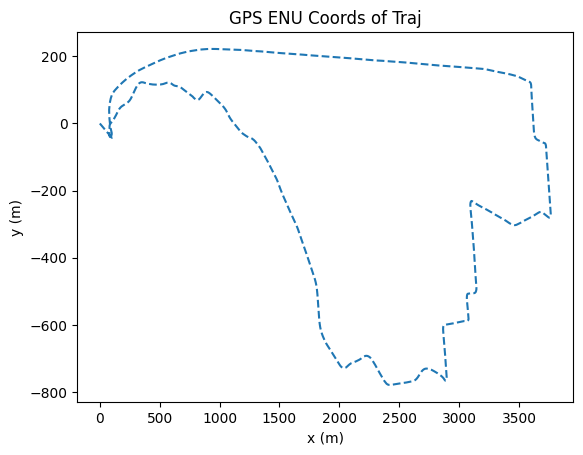

In [113]:
plt.plot(traj_gps_enu_vec[:, 0], traj_gps_enu_vec[:, 1], '--')
plt.title("GPS ENU Coords of Traj")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

## Preprocess Gyro/Accel Measurements to XY ENU Coords

Procedure:
1. Remove Accel/Gyro Bias
2. Integrate Accel to get Vel and Gyro to get $\theta$
3. Use INS model to get XY coords rate of changes (speed) 
4. Integarte $\dot{p}_x$, $\dot{p}_y$ to get XY coords pos

### First integrate without removing bias

In [117]:
def f(x, y, v, theta):
    return np.array([[v*np.cos(theta)],
                     [v*np.sin(theta)]])

In [120]:
jc = ag.jacobian(f)
jc(1, 1, 1, 1)

TypeError: Can't differentiate w.r.t. type <class 'int'>

## Implementation of KF and EKF Filters

In [348]:
# ref: https://en.wikipedia.org/wiki/Kalman_filter
class DiscreteKF:
    def __init__(self, A_k, B_k, H_k, Q_k, R_k):
        self.Ak = A_k
        self.Bk = B_k
        self.Hk = H_k
        self.Qk = Q_k
        self.Rk = R_k
        self.xk_minus = None
        self.Pk_minus = None

    def init_filter(self, x0, P0):
        self.xk_minus = x0
        self.Pk_minus = P0 

    def predict(self, uk_minus):
        if self.xk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")
        if self.Pk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")

        # Project state ahead.
        pred =  self.Ak @ self.xk_minus + self.Bk @ uk_minus
        assert pred.shape == (2, 1)
        self.xk_minus = pred

        # Project error cov ahead.
        self.Pk_minus = self.Ak @ self.Pk_minus @ np.transpose(self.Ak) + self.Qk


    def correct(self, zk):
        if self.xk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")
        if self.Pk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")

        # Compute kalman gain.
        Kyy = self.Hk @ self.Pk_minus @ np.transpose(self.Hk) + self.Rk
        gain = self.Pk_minus @ np.transpose(self.Hk) 
        ##print(f"shape(Kyy): {Kyy.shape}, shape(gain): {gain.shape}")
        gain = gain @ np.linalg.inv(Kyy)
        ##print(f"shape(Kyy): {Kyy.shape}, shape(gain): {gain.shape}")

        # Innovate (correct estimate based on new measurement).
        zk_minus = self.Hk @ self.xk_minus
        corr = self.xk_minus + gain @ (zk - zk_minus)
        assert corr.shape == (2, 1)
        self.xk_minus = corr

        # Correct cov err.
        I = np.eye(self.Pk_minus.shape[0])
        self.Pk_minus = (I - gain @ self.Hk) @ np.linalg.inv(self.Pk_minus)

    def get_state_estim(self):
        return self.xk_minus

In [213]:
# ref: https://en.wikipedia.org/wiki/Extended_Kalman_filter
class DiscreteEKF:
    # TODO: Figure-out Jacobians.
    def __init__(self, f, h, Q_k, R_k):
        self.f = f # nonlinear dynamics model
        self.h = h # nonlinear measurement model
        self.Qk = Q_k
        self.Rk = R_k
        self.xk_minus = None
        self.Pk_minus = None

    def init_filter(self, x0, P0):
        self.xk_minus = x0
        self.Pk_minus = P0 

    def predict(self, uk_minus):
        if self.xk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")
        if self.Pk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")

        # Project state ahead.
        self.xk_minus = self.f(self.xk_minus, uk_minus)
        
        # Compute Jacobian of non-linear state transition model.
        Ak = ag.jacobian(self.f) # df/dx
        Ak(self.xk_minus, uk_minus)

        # Project error cov ahead.
        self.Pk_minus = Ak @ self.Pk_minus @ np.transpose(Ak) + self.Qk

    def correct(self, zk):
        if self.xk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")
        if self.Pk_minus is None:
            raise Exception("Error: initalize the filter first by calling init_filter ...")

        # Compute Jacobian of non-linear measurement transition model.
        Hk = ag.jacobian(self.h) # dh/dx

        # Compute kalman gain.
        Kyy = Hk @ self.Pk_minus @ np.transpose(Hk) + self.Rk
        gain = self.Pk_minus @ np.transpose(Hk) @ np.linalg.inv(Kyy)

        # Innovate.
        zk_minus = self.h(self.xk_minus)
        self.xk_minus = self.xk_minus + gain @ (zk - zk_minus)

        # Correct cov err.
        I = np.eye(self.Pk_minus.shape[0])
        self.Pk_minus = (I - gain @ self.Hk) @ np.linalg.inv(self.Pk_minus)

## Fuse GPS and INS Vel/Heading Measurements

State vector:

$$
x = \left(\begin{matrix}
  v \\
  \theta 
\end{matrix}\right)
$$

IMU Dynamics Equations:

$$
\begin{align}
\dot{v}(t) &= a(t) + b_a(t) + \nu_a(t) \\
\dot{\theta}(t) &= \omega(t) + b_{\omega}(t) + \nu_{\omega}(t),
\end{align}
$$
where $$u(t) = \left[a_m(t), \omega_m(t) \right]^T$$

GPS Measurement Equations:

$$
\begin{align}
v(t) &= v(t) + \nu_{GPS}(t) \\
\theta(t) &= \theta(t) + \nu_{GPS}(t)
\end{align}

Thus,

$$
A_c = \left(\begin{matrix}
  0 & 0 \\
  0 & 0 
\end{matrix}\right)
 $$

$$
B_c = \left(\begin{matrix}
  1 & 0 \\
  0 & 1 
\end{matrix}\right)
 $$

$$
H_k = \left(\begin{matrix}
  1 & 1 \\
\end{matrix}\right)
$$

Discritizing using Euler Forward method:

$$
A_k = \left(\begin{matrix}
  1 & 0 \\
  0 & 1 
\end{matrix}\right)
 $$

$$
B_k = \left(\begin{matrix}
  T & 0 \\
  0 & T 
\end{matrix}\right)
 $$

$$
H_k = \left(\begin{matrix}
  1 & 1 \\
\end{matrix}\right)
$$
where $T$ is the sampling rate of the IMU sensor.

Determining $Q_k$ and $R_k$ based on given $Q(t)$ and $R_k$:

$$
Q(k) = E\left[B_kw(k)\left(B_kw(k)\right)^T\right] = B_kE\left[w(k)w^T(k)\right]B_k^T,
$$
where $E\left[w(k)w^T(k)\right]$ is just the covariance of the process noise introduced by the inputs $\sigma_{\eta}^2$.

So, 
$$
Q_k = \left(\begin{matrix}
  12.5T^2 & 0 \\
  0 & 0.001T^2 
\end{matrix}\right),
$$
based on the given values $Var\left[\nu_a\right] = 12.5m^2/s^4$ and $Var\left[\nu_{\omega}\right] = 0.001 rad^2/s^2$, 

Here, assume 
$$
R_k = 0.06
$$



> Usually these two parameters $Q_k$ and $R_k$ have to get tuned.



In [124]:
T = 0.05
A_k = np.array([[1, 0],
                [0, 1]])
B_k = np.array([[T, 0],
                [0, T]])
H_k = np.array([1, 1]).reshape((1, 2))
Q_k = np.array([[12.5*T**2, 0],
                [0, 0.001*T**2]])
R_k = np.array([[0.06, 0],
                [0, 0.06]])

In [ ]:
A_k.shape, A_k

((2, 2),
 array([[1, 0],
        [0, 1]]))

In [127]:
B_k.shape, B_k

((2, 2),
 array([[0.05, 0.  ],
        [0.  , 0.05]]))

In [128]:
H_k.shape, H_k

((1, 2), array([[1, 1]]))

In [129]:
Q_k.shape, Q_k

((2, 2),
 array([[3.125e-02, 0.000e+00],
        [0.000e+00, 2.500e-06]]))

In [130]:
R_k.shape, R_k

((2, 2),
 array([[0.06, 0.  ],
        [0.  , 0.06]]))

In [131]:
heading_speed_kf = DiscreteKF(A_k, B_k, H_k, Q_k, R_k)

### Finding Properties of Data and Sequencing 

In [ ]:
traj_acc_yaxis_vec = traj_acc_df.loc[:, 'Acceleration y (m/s^2)'].to_numpy()
traj_acc_time_vec = traj_acc_df.loc[:, 'Time (s)'].to_numpy()
traj_gyr_zaxis_vec = traj_gyr_df.loc[:, 'Gyroscope z (rad/s)'].to_numpy()
traj_gyr_time_vec = traj_gyr_df.loc[:, 'Time (s)'].to_numpy()
traj_gps_vel_vec = traj_gps_df.loc[:, 'Velocity (m/s)'].to_numpy()
traj_gps_theta_vec = traj_gps_df.loc[:, 'Direction (°)'].to_numpy()
traj_gps_time_vec = traj_gps_df.loc[:, 'Time (s)'].to_numpy()

In [137]:
# Find sampling frequency and period.
T_acc = traj_acc_time_vec[1] - traj_acc_time_vec[0]
Fs_acc = 1 / T_acc
f"Sampling properties (ACCEL): {T_acc}s, {Fs_acc}Hz"

'Sampling properties (ACCEL): 0.002100000000000001s, 476.1904761904759Hz'

In [138]:
# Find sampling frequency and period.
T_gyr = traj_gyr_time_vec[1] - traj_gyr_time_vec[0]
Fs_gyr = 1 / T_gyr
f"Sampling properties (GYRO): {T_gyr}s, {Fs_gyr}Hz"

'Sampling properties (GYRO): 0.0022000000000000006s, 454.54545454545445Hz'

In [139]:
# Find sampling frequency and period.
T_gps = traj_gps_time_vec[1] - traj_gps_time_vec[0]
Fs_gps = 1 / T_gps
f"Sampling properties (GPS): {T_gps}s, {Fs_gps}Hz"

'Sampling properties (GPS): 1.948016765s, 0.5133426046258899Hz'

In [150]:
traj_gps_theta_vec[0:20], traj_gps_theta_vec.shape

(array([ 61.18936157,  61.18936157,  61.18936157,  61.18936157,
         61.18936157,  61.18936157,  61.18936157,  61.18936157,
         61.18936157,  61.18936157,  61.18936157,  61.18936157,
         61.18936157,  47.52893829,  28.32525063, 358.6938477 ,
        334.2663879 , 325.7847595 , 324.9186401 , 327.6142273 ]),
 (791,))

In [ ]:
# Convert GPS heading to rad.
traj_gps_theta_vec = np.deg2rad(traj_gps_theta_vec)
traj_gps_theta_vec[0:20], traj_gps_theta_vec.shape

(array([1.06795583, 1.06795583, 1.06795583, 1.06795583, 1.06795583,
        1.06795583, 1.06795583, 1.06795583, 1.06795583, 1.06795583,
        1.06795583, 1.06795583, 1.06795583, 0.82953646, 0.49436888,
        6.26038865, 5.83404905, 5.68601671, 5.67090007, 5.71794694]),
 (791,))

In [ ]:
# Make GPS heading consistent with GYRO reference frame.
traj_gps_theta_vec = -traj_gps_theta_vec
traj_gps_theta_vec[0:20], traj_gps_theta_vec.shape

(array([-1.06795583, -1.06795583, -1.06795583, -1.06795583, -1.06795583,
        -1.06795583, -1.06795583, -1.06795583, -1.06795583, -1.06795583,
        -1.06795583, -1.06795583, -1.06795583, -0.82953646, -0.49436888,
        -6.26038865, -5.83404905, -5.68601671, -5.67090007, -5.71794694]),
 (791,))

In [154]:
num_acc = traj_acc_time_vec.shape[0]
num_gyr = traj_gyr_time_vec.shape[0]
num_gps = traj_gps_time_vec.shape[0]
f"ACC: {num_acc}, GYR: {num_gyr}, GPS: {num_gps}"

'ACC: 372578, GYR: 372574, GPS: 791'

In [155]:
ACCEL_TYPE = "ACCEL"
GYRO_TYPE = "GYRO"
GPS_VEL_TYPE = "GPS_VEL"
GPS_THETA_TYPE = "GPS_THETA"
GPS_X_TYPE = "GPS_X"
GPS_Y_TYPE = "GPS_Y"
GPS_Z_TYPE = "GPS_Z"

acc_seq_df = pd.DataFrame({
    "Time (s)": traj_acc_time_vec,
    "Measurement": traj_acc_yaxis_vec,
    "Type": np.repeat(ACCEL_TYPE, num_acc)
    })

gyr_seq_df = pd.DataFrame({
    "Time (s)": traj_gyr_time_vec,
    "Measurement": traj_gyr_zaxis_vec,
    "Type": np.repeat(GYRO_TYPE, num_gyr)
    })

gps_vel_seq_df = pd.DataFrame({
    "Time (s)": traj_gps_time_vec,
    "Measurement": traj_gps_vel_vec,
    "Type": np.repeat(GPS_VEL_TYPE, num_gps)
    })

gps_theta_seq_df = pd.DataFrame({
    "Time (s)": traj_gps_time_vec,
    "Measurement": traj_gps_theta_vec,
    "Type": np.repeat(GPS_THETA_TYPE, num_gps)
    })

gps_x_seq_df = pd.DataFrame({
    "Time (s)": traj_gps_time_vec,
    "Measurement": traj_gps_enu_vec[:, 0],
    "Type": np.repeat(GPS_X_TYPE, num_gps)
    })

gps_y_seq_df = pd.DataFrame({
    "Time (s)": traj_gps_time_vec,
    "Measurement": traj_gps_enu_vec[:, 1],
    "Type": np.repeat(GPS_Y_TYPE, num_gps)
    })

gps_z_seq_df = pd.DataFrame({
    "Time (s)": traj_gps_time_vec,
    "Measurement": traj_gps_enu_vec[:, 2],
    "Type": np.repeat(GPS_Z_TYPE, num_gps)
    })

In [156]:
acc_seq_df.head()

,Time (s),Measurement,Type
0,0.0225,-0.282,ACCEL
1,0.0246,-0.282,ACCEL
2,0.0267,-0.277,ACCEL
3,0.0289,-0.191,ACCEL
4,0.0310,-0.153,ACCEL


In [157]:
gyr_seq_df.head()

,Time (s),Measurement,Type
0,0.0310,-0.001110,GYRO
1,0.0332,-0.001110,GYRO
2,0.0353,0.000111,GYRO
3,0.0374,0.000264,GYRO
4,0.0396,0.000111,GYRO


In [158]:
gps_vel_seq_df.head()

,Time (s),Measurement,Type
0,0.000000,0.0,GPS_VEL
1,1.948017,0.0,GPS_VEL
2,3.043338,0.0,GPS_VEL
3,4.052077,0.0,GPS_VEL
4,5.085355,0.0,GPS_VEL


In [159]:
gps_theta_seq_df.head()

,Time (s),Measurement,Type
0,0.000000,-1.067956,GPS_THETA
1,1.948017,-1.067956,GPS_THETA
2,3.043338,-1.067956,GPS_THETA
3,4.052077,-1.067956,GPS_THETA
4,5.085355,-1.067956,GPS_THETA


In [160]:
gps_x_seq_df.head()

,Time (s),Measurement,Type
0,0.000000,0.000000,GPS_X
1,1.948017,100.933099,GPS_X
2,3.043338,99.547522,GPS_X
3,4.052077,99.412861,GPS_X
4,5.085355,99.469176,GPS_X


In [161]:
gps_y_seq_df.head()

,Time (s),Measurement,Type
0,0.000000,0.000000,GPS_Y
1,1.948017,-42.676186,GPS_Y
2,3.043338,-36.943560,GPS_Y
3,4.052077,-36.182214,GPS_Y
4,5.085355,-36.530077,GPS_Y


In [162]:
gps_z_seq_df.head()

,Time (s),Measurement,Type
0,0.000000,0.000000,GPS_Z
1,1.948017,-29.530702,GPS_Z
2,3.043338,-29.640088,GPS_Z
3,4.052077,-35.422770,GPS_Z
4,5.085355,-36.523868,GPS_Z


In [334]:
data_seq_df = pd.concat((acc_seq_df, gyr_seq_df, gps_vel_seq_df, gps_theta_seq_df, gps_x_seq_df, gps_y_seq_df, gps_z_seq_df), ignore_index=True)
data_seq_df.head(), data_seq_df.tail()

(   Time (s)  Measurement   Type
 0    0.0225       -0.282  ACCEL
 1    0.0246       -0.282  ACCEL
 2    0.0267       -0.277  ACCEL
 3    0.0289       -0.191  ACCEL
 4    0.0310       -0.153  ACCEL,
           Time (s)  Measurement   Type
 749102  793.605199   -31.693586  GPS_Z
 749103  794.605227   -31.619192  GPS_Z
 749104  795.605238   -31.652378  GPS_Z
 749105  796.605272   -31.644122  GPS_Z
 749106  797.605318   -31.633364  GPS_Z)

In [184]:
num_rows = num_acc + num_gyr + 5*num_gps
num_rows

749107

In [335]:
# Sort by time.
data_seq_df.sort_values(by=['Time (s)', 'Type']).head(20)

,Time (s),Measurement,Type
745943,0.0000,-1.067956,GPS_THETA
745152,0.0000,0.000000,GPS_VEL
746734,0.0000,0.000000,GPS_X
747525,0.0000,0.000000,GPS_Y
748316,0.0000,0.000000,GPS_Z
0,0.0225,-0.282000,ACCEL
1,0.0246,-0.282000,ACCEL
2,0.0267,-0.277000,ACCEL
3,0.0289,-0.191000,ACCEL
4,0.0310,-0.153000,ACCEL


In [336]:
data_seq_df.sort_values(by=['Time (s)', 'Type'], inplace=True)

In [337]:
data_seq_df.head(20)

,Time (s),Measurement,Type
745943,0.0000,-1.067956,GPS_THETA
745152,0.0000,0.000000,GPS_VEL
746734,0.0000,0.000000,GPS_X
747525,0.0000,0.000000,GPS_Y
748316,0.0000,0.000000,GPS_Z
0,0.0225,-0.282000,ACCEL
1,0.0246,-0.282000,ACCEL
2,0.0267,-0.277000,ACCEL
3,0.0289,-0.191000,ACCEL
4,0.0310,-0.153000,ACCEL


In [185]:
data_seq_df.reindex(list(range(num_rows))).head(20)

,Time (s),Measurement,Type
0,0.0225,-0.282,ACCEL
1,0.0246,-0.282,ACCEL
2,0.0267,-0.277,ACCEL
3,0.0289,-0.191,ACCEL
4,0.0310,-0.153,ACCEL
5,0.0332,-0.230,ACCEL
6,0.0353,-0.258,ACCEL
7,0.0374,-0.306,ACCEL
8,0.0396,-0.330,ACCEL
9,0.0417,-0.388,ACCEL


In [186]:
data_seq_df.head(20)

,Time (s),Measurement,Type
745152,0.0000,0.000000,GPS_VEL
745943,0.0000,-1.067956,GPS_THETA
746734,0.0000,0.000000,GPS_X
747525,0.0000,0.000000,GPS_Y
748316,0.0000,0.000000,GPS_Z
0,0.0225,-0.282000,ACCEL
1,0.0246,-0.282000,ACCEL
2,0.0267,-0.277000,ACCEL
3,0.0289,-0.191000,ACCEL
372578,0.0310,-0.001110,GYRO


In [187]:
data_seq_df.reset_index(drop=True).head(20)

,Time (s),Measurement,Type
0,0.0000,0.000000,GPS_VEL
1,0.0000,-1.067956,GPS_THETA
2,0.0000,0.000000,GPS_X
3,0.0000,0.000000,GPS_Y
4,0.0000,0.000000,GPS_Z
5,0.0225,-0.282000,ACCEL
6,0.0246,-0.282000,ACCEL
7,0.0267,-0.277000,ACCEL
8,0.0289,-0.191000,ACCEL
9,0.0310,-0.001110,GYRO


In [338]:
data_seq_df.reset_index(drop=True, inplace=True)

In [339]:
data_seq_df.head(20)

,Time (s),Measurement,Type
0,0.0000,-1.067956,GPS_THETA
1,0.0000,0.000000,GPS_VEL
2,0.0000,0.000000,GPS_X
3,0.0000,0.000000,GPS_Y
4,0.0000,0.000000,GPS_Z
5,0.0225,-0.282000,ACCEL
6,0.0246,-0.282000,ACCEL
7,0.0267,-0.277000,ACCEL
8,0.0289,-0.191000,ACCEL
9,0.0310,-0.153000,ACCEL


In [340]:
for i, row in data_seq_df.iterrows():
    if (i == 20):
        break
    t, zk, typ = row
    print(f"{i}: {t}, {zk}, {typ}")

0: 0.0, -1.0679558265897868, GPS_THETA
1: 0.0, 0.0, GPS_VEL
2: 0.0, 0.0, GPS_X
3: 0.0, 0.0, GPS_Y
4: 0.0, 0.0, GPS_Z
5: 0.0225, -0.282, ACCEL
6: 0.0246, -0.282, ACCEL
7: 0.0267, -0.277, ACCEL
8: 0.0289, -0.191, ACCEL
9: 0.031, -0.153, ACCEL
10: 0.031, -0.00111, GYRO
11: 0.0332, -0.23, ACCEL
12: 0.0332, -0.00111, GYRO
13: 0.0353, -0.258, ACCEL
14: 0.0353, 0.000111, GYRO
15: 0.0374, -0.306, ACCEL
16: 0.0374, 0.000264, GYRO
17: 0.0396, -0.33, ACCEL
18: 0.0396, 0.000111, GYRO
19: 0.0417, -0.388, ACCEL


## Run Kalman Filter for Heading/Vel Estimation

Assumptions:
- Initial conditions have unit variance I

In [349]:
A_k = np.array([[1, 0],
                [0, 1]])
B_k = np.array([[T_acc, 0],
                [0, T_gyr]])
H_k = np.array([[1, 0],
                [0, 1]
                ])
Q_k = np.array([[12.5*T_acc**2, 0],
                [0, 0.001*T_gyr**2]])
R_k = np.array([[0.06, 0],
                [0, 0.06]])

In [350]:
heading_speed_kf = DiscreteKF(A_k, B_k, H_k, Q_k, R_k)

In [351]:
print(heading_speed_kf.get_state_estim())

None


In [352]:
# Initialize with I.C.
x0 = np.array([0, np.deg2rad(28.8)]).reshape((2, 1))
P0 = np.eye(2)
x0, P0

(array([[0.        ],
        [0.50265482]]),
 array([[1., 0.],
        [0., 1.]]))

In [353]:
heading_speed_kf.init_filter(x0, P0)

In [354]:
data_seq_df.iloc[1]['Measurement']

np.float64(0.0)

In [355]:
pred_vel_log = []
pred_theta_log = []
time_log = []
for i, row in data_seq_df.iterrows():
    t, zk, typ = row

    if (typ == GPS_VEL_TYPE):
        continue
    elif (typ == GPS_X_TYPE):
        continue
    elif (typ == GPS_Y_TYPE):
        continue
    elif (typ == GPS_Z_TYPE):
        continue

    pred = heading_speed_kf.get_state_estim()
    ##print(pred, type(pred), pred.shape)
    pred_vel_log.append(pred[0])
    pred_theta_log.append(pred[1])
    time_log.append(t)

    if (typ == ACCEL_TYPE):
        uk = np.array([zk, 0]).reshape((2, 1))
        heading_speed_kf.predict(uk)

    elif (typ == GYRO_TYPE):
        uk = np.array([0, zk]).reshape((2, 1))
        heading_speed_kf.predict(uk)

    elif (typ == GPS_THETA_TYPE):
        assert data_seq_df.iloc[i]['Type'] == GPS_THETA_TYPE
        assert data_seq_df.iloc[i+1]['Type'] == GPS_VEL_TYPE
        assert data_seq_df.iloc[i+2]['Type'] == GPS_X_TYPE
        assert data_seq_df.iloc[i+3]['Type'] == GPS_Y_TYPE
        assert data_seq_df.iloc[i+4]['Type'] == GPS_Z_TYPE

        yk_theta = data_seq_df.iloc[i]['Measurement']
        yk_vel = data_seq_df.iloc[i+1]['Measurement']
        yk_x = data_seq_df.iloc[i+2]['Measurement']
        yk_y = data_seq_df.iloc[i+3]['Measurement']
        yk_z = data_seq_df.iloc[i+4]['Measurement']
        zk = np.array([yk_vel, yk_theta]).reshape(2, 1)
        heading_speed_kf.correct(zk)


In [356]:
len(time_log), len(pred_theta_log)

(745943, 745943)

In [357]:
pred_theta_log[0]

array([0.50265482])

Text(0, 0.5, 'Vel (m/s)')

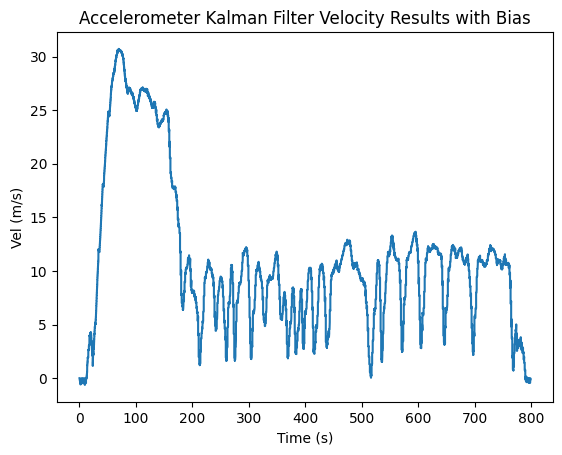

In [ ]:
plt.plot(time_log, pred_vel_log)
plt.title("Accelerometer Kalman Filter Velocity Results with Bias")
plt.xlabel("Time (s)")
plt.ylabel("Vel (m/s)")

Text(0, 0.5, '$\\theta$ (rad)')

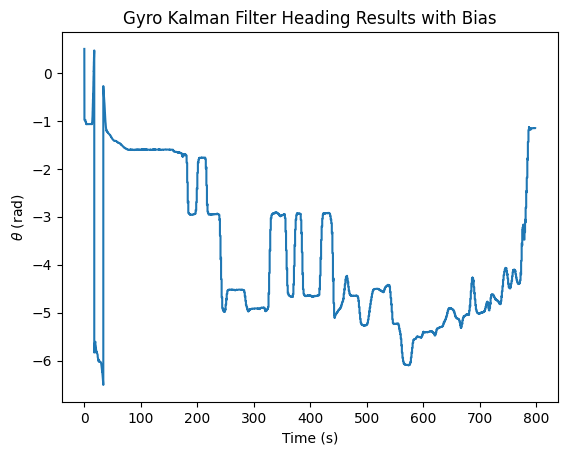

In [359]:
plt.plot(time_log, pred_theta_log)
plt.title("Gyro Kalman Filter Heading Results with Bias")
plt.xlabel("Time (s)")
plt.ylabel("$\\theta$ (rad)")

## Plot Vel/Heading KF Results

In [363]:
vel_cum = np.cumsum(traj_acc_yaxis_vec)*T_acc
theta_cum = np.cumsum(traj_gyr_zaxis_vec)*T_gyr
assert vel_cum.shape == traj_acc_time_vec.shape
assert theta_cum.shape == traj_gyr_time_vec.shape

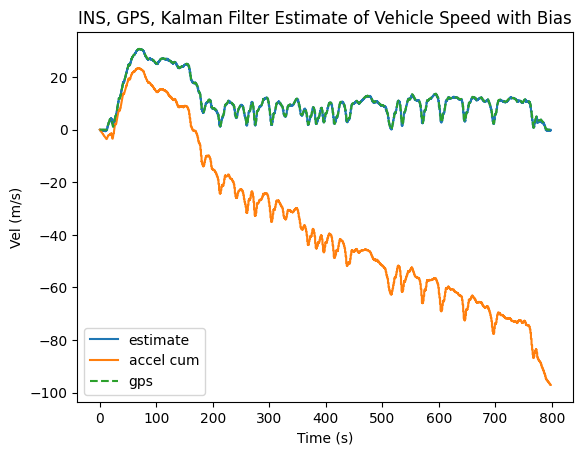

In [372]:
# Plot INS, GPS, Kalman Filter estimate of vehicle speed over time.
plt.title("INS, GPS, Kalman Filter Estimate of Vehicle Speed with Bias")
plt.xlabel("Time (s)")
plt.ylabel("Vel (m/s)")
plt.plot(time_log, pred_vel_log, label="estimate")
plt.plot(traj_acc_time_vec, vel_cum, label="accel cum")
plt.plot(traj_gps_time_vec, traj_gps_vel_vec, "--", label="gps")
plt.legend()

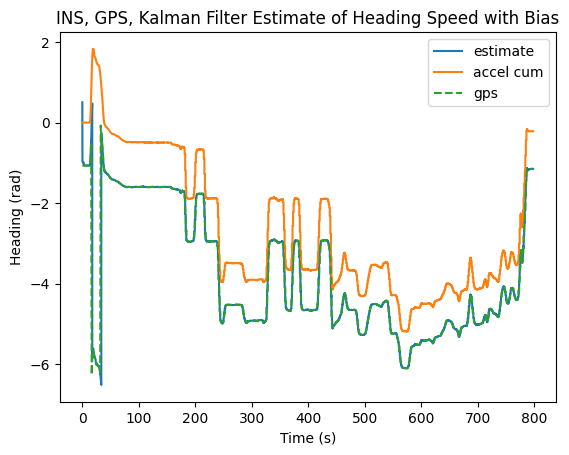

In [374]:
# Plot INS, GPS, Kalman Filter estimate of vehicle heading over time.
plt.title("INS, GPS, Kalman Filter Estimate of Heading Speed with Bias")
plt.xlabel("Time (s)")
plt.ylabel("Heading (rad)")
plt.plot(time_log, pred_theta_log, label="estimate")
plt.plot(traj_gyr_time_vec, theta_cum, label="accel cum")
plt.plot(traj_gps_time_vec, traj_gps_theta_vec, "--", label="gps")
plt.legend()